In [1]:
# Imports here

import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim import lr_scheduler
from collections import OrderedDict
import os
import time
import copy
import json
from PIL import Image

In [2]:
data_dir = 'data'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
      }


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])
                  for x in ['train', 'valid','test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4)
              for x in ['train', 'valid','test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid','test']}

In [77]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [5]:
model = models.densenet121(pretrained=True)

c:\users\hp\appdata\local\conda\conda\envs\cv-nd\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [6]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier.in_features
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(num_ftrs, 500)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.5)),
                          ('fc2', nn.Linear(500, 3)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.2f}'.format(
                phase, epoch_loss, 100 * epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:2f}'.format(100*best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    

In [9]:
model = model.to(device)

criterion = nn.NLLLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [10]:
train_model(model, criterion, optimizer, scheduler = exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 0.8374 Acc: 68.40
valid Loss: 0.9101 Acc: 54.00

Epoch 1/19
----------
train Loss: 0.7904 Acc: 68.25
valid Loss: 0.9258 Acc: 53.33

Epoch 2/19
----------
train Loss: 0.7832 Acc: 67.90
valid Loss: 0.8339 Acc: 59.33

Epoch 3/19
----------
train Loss: 0.7460 Acc: 69.75
valid Loss: 0.8952 Acc: 58.00

Epoch 4/19
----------
train Loss: 0.7808 Acc: 68.35
valid Loss: 0.9065 Acc: 53.33

Epoch 5/19
----------
train Loss: 0.7484 Acc: 68.50
valid Loss: 0.9065 Acc: 54.67

Epoch 6/19
----------
train Loss: 0.7322 Acc: 69.50
valid Loss: 0.8546 Acc: 61.33

Epoch 7/19
----------
train Loss: 0.7187 Acc: 69.90
valid Loss: 0.8466 Acc: 64.00

Epoch 8/19
----------
train Loss: 0.7054 Acc: 69.55
valid Loss: 0.7886 Acc: 65.33

Epoch 9/19
----------
train Loss: 0.6997 Acc: 70.70
valid Loss: 0.8161 Acc: 64.67

Epoch 10/19
----------
train Loss: 0.6850 Acc: 72.05
valid Loss: 0.8514 Acc: 63.33

Epoch 11/19
----------
train Loss: 0.7002 Acc: 71.70
valid Loss: 0.8260 Acc: 63.33

Ep

In [11]:
def test_model(phase):    
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for (inputs, labels) in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    print('Accuracy of the network on test images: %d %%' % (100 * correct / total))
    
test_model('test')    

Accuracy of the network on test images: 69 %


In [13]:
# Save the checkpoint 
model.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {'arch' : 'densenet121',
              'classifier' : model.classifier,
              'state_dict' : model.state_dict(),
              'optimizer' : optimizer,
              'optimizer_dict' : optimizer.state_dict(),
              
              'class_to_idx' : model.class_to_idx}

torch.save(checkpoint, 'checkpoint.pth')

In [52]:
# function that loads a checkpoint and rebuilds the model

def load_checkpoint(checkpoint):
    checkpoint = torch.load(checkpoint)
    model = getattr(models, checkpoint['arch'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    for param in model.parameters():
        param.requires_grad = False
    model.load_state_dict(checkpoint['state_dict'])
    model.optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model


model = load_checkpoint('checkpoint.pth')

c:\users\hp\appdata\local\conda\conda\envs\cv-nd\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [28]:
def process_image(image):
    
    
    image = image.resize((round(256*image.size[0]/image.size[1]) if image.size[0]>image.size[1] else 256,
                          round(256*image.size[1]/image.size[0]) if image.size[1]>image.size[0] else 256))  
    
    image = image.crop((image.size[0]/2-224/2, image.size[1]/2-224/2, image.size[0]/2+224/2, image.size[1]/2+224/2))

    np_image = (np.array(image)/255-[0.485,0.456,0.406])/[0.229, 0.224, 0.225]
    np_image = np_image.transpose((2,0,1))
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    return torch.from_numpy(np_image)


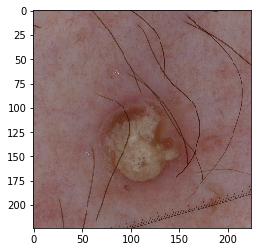

In [162]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
image = Image.open('images/test_image3.jpg')
imshow(process_image(image))

In [163]:
def predict(image_path, model, topk=3):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    im = Image.open(image_path)
    processed_im = process_image(im).unsqueeze(0)
    model.to(device)
    model.eval()    
    with torch.no_grad():
        processed_im = processed_im.to('cuda').float()
        output = model(processed_im)
        ps = torch.exp(output)
    pred = ps.topk(topk)
    skin_ids = pred[1][0].to('cpu')
    skin_ids = torch.Tensor.numpy(skin_ids)
    probs = pred[0][0].to('cpu')
    idx_to_class = {k:v for v,k in checkpoint['class_to_idx'].items()}
    skin_names = np.array([idx_to_class[x] for x in skin_ids])
        
    return probs, skin_names


<Container object of 3 artists>

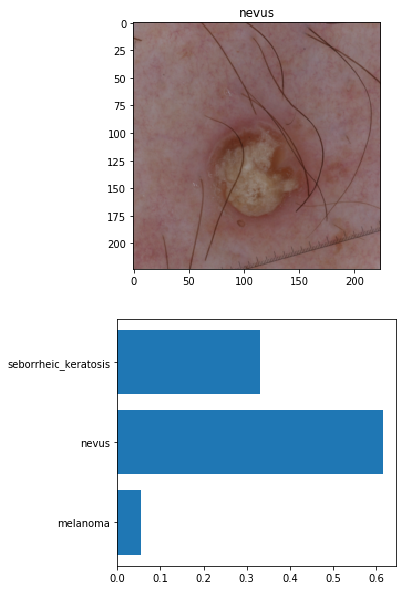

In [165]:
# Display an image along with the top classes
image_path = 'images/test_image3.jpg'
probs, skin_names = predict(image_path, model)

fig, ax = plt.subplots(2,figsize=(5,10))
tranfs = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
ax[0].set_title(skin_names[0])
ax[0].imshow(tranfs(image))
ax[1].barh(skin_names, probs)


In [ ]:
#finish